<a href="https://colab.research.google.com/github/annisakumaladewi/ab_testing/blob/main/A_B_Testing_Project_1_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

checkout = pd.read_csv('checkout.csv')
checkout

,Unnamed: 0,user_id,checkout_page,order_value,purchased,gender,browser,time_on_page
0,0,877621,A,29.410131,1.0,F,chrome,66.168628
1,1,876599,A,NaN,0.0,M,firefox,49.801887
2,2,905407,A,27.446845,1.0,M,chrome,56.744856
3,3,883562,A,30.602233,1.0,M,safari,71.890718
4,4,840542,A,29.668895,1.0,F,safari,67.410696
...,...,...,...,...,...,...,...,...
8995,8995,903591,C,45.395883,1.0,M,safari,63.291767
8996,8996,883490,C,30.462670,1.0,F,safari,33.425340
8997,8997,914494,C,34.037979,1.0,M,chrome,40.575958
8998,8998,897280,C,28.937421,1.0,F,chrome,30.374843


## 1. EDA

### Dealing with Missing Values

In [104]:
checkout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     9000 non-null   int64  
 1   user_id        9000 non-null   int64  
 2   checkout_page  9000 non-null   object 
 3   order_value    7605 non-null   float64
 4   purchased      9000 non-null   float64
 5   gender         9000 non-null   object 
 6   browser        9000 non-null   object 
 7   time_on_page   9000 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 562.6+ KB


In [105]:
# add a viz showing missing values in order_value v purchased (showing difference in hue 0 and 1)



*   Missing values found in order_value == this is because order value is NaN when purchased is 0, the user did not make a purchase
*   I dont replace the NaNs with 0 because that will change what the metric means.
*   The average order value (AOV) is defined as: total purchase value ÷ number of purchasers.
*   If I fill NaNs with 0s, my denominator suddenly includes non-purchasers, which turns your metric into something else — basically “revenue per visitor.” - a different KPI.



### Dealing with Duplicates

In [106]:
print(len(checkout))
print(len(checkout.drop_duplicates(keep='first')))

9000
9000


no duplicates detected

### EDA Summary Stats

In [107]:
checkout.groupby('checkout_page')['order_value'].agg({'mean', 'std','median'})

,mean,std,median
checkout_page,,,
A,24.956437,2.418837,24.960552
B,29.876202,7.277644,29.888567
C,34.917589,4.869816,34.933749


*   I can see that mean of order value per checkout page follow the order: C > B > A This suggests that users on checkout page C tend to spend more on purchases on average.
*   B has the biggest SD meaning data is more spread out, and A having the smallest. The higher spread (std) for B indicates more variability in spending behavior, which could hint at inconsistent user experience or diverse buyer types.
*   Median also varies with A having the smallest and C having the biggest middle number
*   Since C has both the highest mean and median, its performance improvement seems consistent, not driven by outliers.

### EDA: Confirm using Data Visualisation

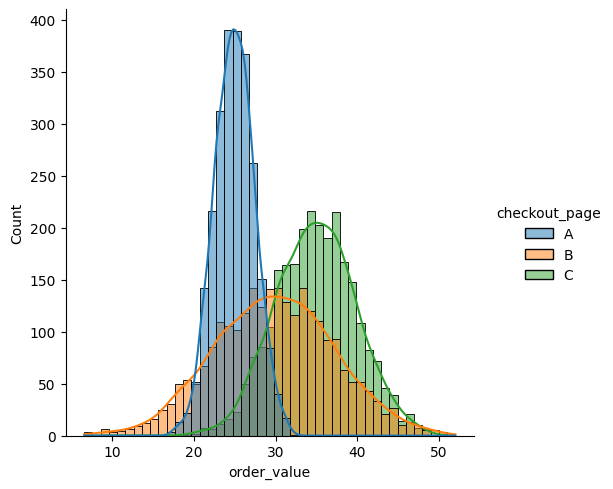

In [108]:
sns.displot(data=checkout, x='order_value', hue = 'checkout_page', kde=True)

*  The order value distributions for the three checkout pages show clear separation.

*  Page A (blue) is tightly clustered around lower order values (~25), suggesting consistent but smaller purchases.

*  Page B (orange) has a wider spread, covering mid-range values (~30) with higher variability.

*  Page C (green) is centered around the highest order values (~35+) with a slightly narrower distribution than B, meaning users spend more and more consistently.

*  This visual supports the earlier descriptive stats: C > B > A in both average and median order values. However, the overlap between B and C suggests the difference, while visible, may not be huge, which can be tested with a t-test for its significance



## 2. Internal and External Validity Checks

| Component           | Example Question                               | Method                  |
| ------------------- | ---------------------------------------------- | ----------------------- |
| SRM                 | Did each group get equal users?                | Chi-square on counts    |
| Demographic Balance | Are attributes (browser/gender) balanced?      | Chi-square on crosstabs |
| A/A Test        | Do identical groups produce identical results? | Z-test on main metric   |


### Internal Validity: Sample Ratio Mismatch

SRM checks if the number of users assigned to each variant matches what I expect. In this case is an equal split between 3 of our checkout pages.

Null Hypothesis: there is no statistically significant difference between the observed and expected group sizes

In [109]:
import scipy.stats as stats

obs = checkout['checkout_page'].value_counts().values # extracts no of times each checkout_page appears
expected = [len(checkout)/3]*3 # total number of users equally divided by 3 - which is the ideal situation
chi2, pval = stats.chisquare(obs, expected)
print(f"Chi-square p-value: {pval}")

Chi-square p-value: 1.0


p-value > 1.0 meaning I accept the null hypothesis that there is no difference between the group sizes. I want to acept this null hypothesis to ensure no internal validity.

### Internal Validity: Demographic Balance

In [110]:
from scipy import stats

def demographic_balance_tests(df, assign_col, covariates, dropna=False):
    """
    Chi-square balance checks for multiple covariates against the assignment column.

    Parameters
    ----------
    df : pd.DataFrame
    assign_col : str
        Column with variant assignment (e.g., 'checkout_page')
    covariates : list[str]
        Columns to test for balance (e.g., ['browser','gender'])
    dropna : bool
        If True, drop NA in covariate before testing; if False, NA is treated as a category.

    Returns
    -------
    pd.DataFrame with: covariate, chi2, dof, p_value, cramers_v, n_categories, min_expected, n_small_expected
    """
    rows = []
    for cov in covariates:
        sub = df[[assign_col, cov]].copy()
        if dropna:
            sub = sub.dropna(subset=[cov])
        # contingency table (NA as its own level if dropna=False)
        table = pd.crosstab(sub[assign_col], sub[cov], dropna=False)

        # chi-square test
        chi2, p, dof, expected = stats.chi2_contingency(table)
        n = table.values.sum()
        r, k = table.shape
        # Cramér's V (effect size)
        phi2 = chi2 / n
        cramers_v = np.sqrt(phi2 / max(1, min(r - 1, k - 1)))

        rows.append({
            "covariate": cov,
            "chi2": chi2,
            "dof": dof,
            "p_value": p,
            "cramers_v": cramers_v,
            "n_categories": k,
            "min_expected": float(expected.min()),
            "n_small_expected(<5)": int((expected < 5).sum())
        })
    return pd.DataFrame(rows).sort_values("p_value")



In [111]:
balance = demographic_balance_tests(
    checkout,
    assign_col="checkout_page",
    covariates=["browser", "gender"],
    dropna=False
)
balance


,covariate,chi2,dof,p_value,cramers_v,n_categories,min_expected,n_small_expected(<5)
1,gender,3.852435,2,0.145698,0.020689,2,1477.333333,0
0,browser,3.423705,4,0.489574,0.013792,3,975.666667,0


Analysis:

p-value


*   gender p = 0.146 > 0.05, not significant, gender distribution across checkout pages A, B and C is roughly the same - no imbalance
*   similarly, browser p = 0.490 > 0.05 , no significant differences between browser distribution

Cramer's V

*   anything below 0.1 is negligible => little association measured
*   this matches the p-vales, no imbalance

Therefore, our groups are balanced







### Internal Validity: A/A Testing

In [112]:
from statsmodels.stats.proportion import proportions_ztest

# filter for group A only
group_A = checkout[checkout['checkout_page'] == 'A'].copy()

# randomly split into A1 and A2
np.random.seed(42)
group_A['group'] = np.random.choice(['A1', 'A2'], size=len(group_A))

# calculate purchase per group
AA_summary = group_A.groupby('group')['purchased'].agg(['sum', 'count'])
print(AA_summary)

# run two-sample z-test for proportion (purchase rate)
count = AA_summary['sum'].values
nobs = AA_summary['count'].values
stat, pval = proportions_ztest(count, nobs)
print(f"Z-statistic: {stat:.2f}, P-value: {pval:.2f}")

          sum  count
group               
A1     1247.0   1517
A2     1214.0   1483
Z-statistic: 0.24, P-value: 0.81


p-value > 0.05 → Randomization and measurement pipeline look fine (A1 and A2 behave the same).

### External Validity: Simpson's paradox

This is when I divide the data by different metrics and different trends emerge accordingly. Trends would either dissapear or reverse when the population is divide into segments. The difference in trends is what differs this from A/A Testing.

In [113]:
# overall purchase rate by checkout page
checkout.groupby('checkout_page')['purchased'].mean()

,purchased
checkout_page,
A,0.820333
B,0.847000
C,0.867667


In [114]:
# sub-grouped
checkout.groupby(['checkout_page','browser'])['purchased'].mean().unstack()

browser,chrome,firefox,safari
checkout_page,,,
A,0.807617,0.829592,0.824297
B,0.830753,0.859487,0.850379
C,0.879798,0.866255,0.857418


Shows the same pattern that C > B > A , meaning Simpson'a paradox does not occur.

## 3. Experimental Design

Setting up testing parameters (power analysis and MDE) and deciding sample size needed

Power Analysis - commonly set at 80%

Minimum Detectable Effect: smallest difference I care to capture

I will measure three values:

*   Proportion of users who purchased - proportion test
*   Mean of order_value and time_on_page - mean difference test

### Dealing with Means

In [115]:
from statsmodels.stats.power import FTestAnovaPower

def anova_power_from_data(df, group_col, metric_col, alpha=0.05, power=0.8):
    """
    Estimate ANOVA effect size (Cohen's f) from data and
    compute required sample size per group.
    """
    # 1. split data by group
    groups = [g[metric_col].dropna().values
              for _, g in df.groupby(group_col)]

    k = len(groups)  # number of groups

    # 2. group means
    means = np.array([g.mean() for g in groups])

    # 3. pooled standard deviation (across all groups)
    n_list = [len(g) for g in groups]
    pooled_var = sum((n-1)*g.var(ddof=1) for g, n in zip(groups, n_list)) / (sum(n_list) - k)
    sd = np.sqrt(pooled_var)

    # 4. Cohen's f for ANOVA
    grand_mean = means.mean()
    f = np.sqrt(((means - grand_mean)**2).mean()) / sd

    # 5. power analysis
    analysis = FTestAnovaPower()
    n_per_group = analysis.solve_power(effect_size=f,
                                       alpha=alpha,
                                       power=power,
                                       k_groups=k)

    return {
        "metric": metric_col,
        "groups": k,
        "effect_size_f": f,
        "required_n_per_group": n_per_group,
        "total_required_n": n_per_group * k
    }


In [116]:
# Sample size for time_on_page
anova_power_from_data(checkout, "checkout_page", "time_on_page")

{'metric': 'time_on_page',
 'groups': 3,
 'effect_size_f': np.float64(0.101478136142444),
 'required_n_per_group': 938.6076415600567,
 'total_required_n': 2815.82292468017}

In [117]:
# Sample size for order_value
buyers = checkout[checkout['order_value'].notna()] # drop na values
anova_power_from_data(buyers, "checkout_page", "order_value")

{'metric': 'order_value',
 'groups': 3,
 'effect_size_f': np.float64(0.7725919122054484),
 'required_n_per_group': 19.473271143775232,
 'total_required_n': 58.41981343132569}

### Dealing with Proportions

In [118]:
from itertools import combinations
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

def sample_size_proportion_multigroup(df, group_col, outcome_col, alpha=0.05, power=0.8):
    """
    Computes required sample size per group for detecting differences in proportions
    across 3+ variants in an A/B/n test.

    Parameters:
        df: dataframe
        group_col: column with A/B/C labels
        outcome_col: binary column (0/1)
        alpha: significance level
        power: desired power

    Returns:
        Dictionary with required sample sizes per pair + max needed
    """

    groups = df[group_col].unique()
    results = {}
    analysis = NormalIndPower()

    # Loop through all pairwise combinations (A-B, A-C, B-C)
    for g1, g2 in combinations(groups, 2):
        # Baseline proportion
        p1 = df[df[group_col] == g1][outcome_col].mean()
        # Treatment proportion
        p2 = df[df[group_col] == g2][outcome_col].mean()

        # Effect size (Cohen's h)
        h = proportion_effectsize(p1, p2)

        # Required sample size
        n = analysis.solve_power(effect_size=abs(h),
                                 power=power,
                                 alpha=alpha,
                                 alternative="two-sided")

        results[f"{g1} vs {g2}"] = n

    results["max_required_per_group"] = max(results.values())
    return results


In [119]:
sample_size_proportion_multigroup(
    df=checkout,
    group_col='checkout_page',
    outcome_col='purchased',
    alpha=0.05,
    power=0.8
)

{'A vs B': 3056.58648900793,
 'A vs C': 917.6413105611359,
 'B vs C': 4489.98349643946,
 'max_required_per_group': 4489.98349643946}

This confirms the relationship between sample size and MDE on power. with effect size bigger as can be seen between A and C, I need less number of obs in comparison to B vs C where effect size is smaller.

Hence, to reliably detect any difference in A/B?C purchase rates, the experiment needs roughly 4500 users. The df consists 9000 users so I will have to use the whole population putting in mind it will be underpowered since there will only be 3000 per users.

### Which Sample Size to use?

| Metric                          | N per group | Why                  |
| ------------------------------- | ----------- | -------------------- |
| **Purchased rate (proportion)** | **≈ 4500**  | tiny effect → big N  |
| **Time on page (mean)**         | **≈ 939**   | small effect         |
| **Order value (mean)**          | **≈ 20**    | huge effect → tiny N |



Which sample size to use? Choose the metric requiring the largest N because it ensures the test is sufficiently powered for all KPIs. But in this case, since the df only have 9000 users, I only have 3k users per group. This means for order_value and time_on_page, the tests will be fully powered as it requires much less than 3k users, but for proportion difference on purchased (aka conversion rate) the test will be underpowered.

## 4. Hypothesis Tests

### Analysing Difference in means A/B tests

In [120]:
!pip install pingouin

In [121]:
import pingouin
df = checkout.copy()
df['order_value_filled'] = df['order_value'].fillna(0)

pairwise_order = pingouin.pairwise_tests(data = df,
                                         dv = "order_value_filled",
                                         between = "checkout_page",
                                         padjust = "bonf",
                                         effsize="cohen")

print(pairwise_order)

        Contrast  A  B  Paired  Parametric          T     dof alternative  \
0  checkout_page  A  B   False        True -16.504664  5998.0   two-sided   
1  checkout_page  A  C   False        True -33.549635  5998.0   two-sided   
2  checkout_page  B  C   False        True -15.255639  5998.0   two-sided   

           p-unc         p-corr p-adjust        BF10     cohen  
0   6.990347e-60   2.097104e-59     bonf    1.54e+56 -0.426149  
1  2.586535e-226  7.759605e-226     bonf  1.272e+222 -0.866248  
2   1.390230e-51   4.170691e-51     bonf   8.652e+47 -0.393899  


In [122]:
pairwise_time = pingouin.pairwise_tests(data = checkout,
                                         dv = "time_on_page",
                                         between = "checkout_page",
                                         padjust = "bonf",
                                         effsize="cohen")

print(pairwise_time)

        Contrast  A  B  Paired  Parametric         T     dof alternative  \
0  checkout_page  A  B   False        True  7.026673  5998.0   two-sided   
1  checkout_page  A  C   False        True  8.833244  5998.0   two-sided   
2  checkout_page  B  C   False        True  1.995423  5998.0   two-sided   

          p-unc        p-corr p-adjust       BF10     cohen  
0  2.349604e-12  7.048812e-12     bonf  1.305e+09  0.181428  
1  1.316118e-18  3.948354e-18     bonf  1.811e+15  0.228073  
2  4.604195e-02  1.381258e-01     bonf      0.212  0.051522  


### Analysis Difference in Proportions


In [123]:
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize
import itertools

def pairwise_proportion_tests(df, group_col, outcome_col):

    grouped = df.groupby(group_col)
    successes = grouped[outcome_col].sum()
    nobs = grouped[outcome_col].count()
    p = successes / nobs
    groups = list(successes.index)

    results = []

    for g1, g2 in itertools.combinations(groups, 2):
        stat, pval = proportions_ztest([successes[g1], successes[g2]],
                                       [nobs[g1], nobs[g2]])
        h = proportion_effectsize(p[g1], p[g2])

        results.append({
            "comparison": f"{g1} vs {g2}",
            "p1": p[g1],
            "p2": p[g2],
            "z_stat": stat,
            "p_value": pval,
            "effect_size_h": h
        })

    return results


In [124]:
results = pairwise_proportion_tests(checkout, 'checkout_page', 'purchased')
results

[{'comparison': 'A vs B',
  'p1': np.float64(0.8203333333333334),
  'p2': np.float64(0.847),
  'z_stat': np.float64(-2.773502092305086),
  'p_value': np.float64(0.005545648376115055),
  'effect_size_h': np.float64(-0.07166382073486188)},
 {'comparison': 'A vs C',
  'p1': np.float64(0.8203333333333334),
  'p2': np.float64(0.8676666666666667),
  'z_stat': np.float64(-5.052184437070658),
  'p_value': np.float64(4.367856148120284e-07),
  'effect_size_h': np.float64(-0.13079219400120934)},
 {'comparison': 'B vs C',
  'p1': np.float64(0.847),
  'p2': np.float64(0.8676666666666667),
  'z_stat': np.float64(-2.28865300737992),
  'p_value': np.float64(0.022099521426815694),
  'effect_size_h': np.float64(-0.059128373266347456)}]

In [125]:
# apply FWER bonferroni correction as it tests more than once - 3 pairwise tests

def add_bonferroni(results, alpha=0.05):
    m = len(results)                  # number of pairwise comparisons
    alpha_bonf = alpha / m            # adjusted significance threshold

    for r in results:
        p = r["p_value"]
        r["p_bonf"] = min(p * m, 1.0) # Bonferroni corrected p-value
        r["alpha_bonf"] = alpha_bonf  # store threshold for reference
        r["significant"] = r["p_bonf"] < alpha_bonf

    return results

results_bonf = add_bonferroni(results)

for r in results_bonf:
    print(r["comparison"],
          "| original p:", round(r["p_value"], 5),
          "| p_bonf:", round(r["p_bonf"], 5),
          "| alpha_bonf:", round(r["alpha_bonf"], 5),
          "| significant?", r["significant"])


A vs B | original p: 0.00555 | p_bonf: 0.01664 | alpha_bonf: 0.01667 | significant? True
A vs C | original p: 0.0 | p_bonf: 0.0 | alpha_bonf: 0.01667 | significant? True
B vs C | original p: 0.0221 | p_bonf: 0.0663 | alpha_bonf: 0.01667 | significant? False


## 5. Experimenting with Non-parametric statistical tests

Previously, I ran parametric tests to find effect size (mean or proportion difference) between groups A, B and C. Now, this is not always the case. Parametric tests can only be implemented to data that are:



*   Randomly Sampled
*   Independence: each obs is independent unless they are paired (then I use pairwise t-test)
*   Normally distributed, and have "enough" sample size. For two-sample t-test, n>= 30 in each group and for two sample proportion test: >=10 successes and >=10 failures in each group



### Mann-Whitney U test



*   Determines if two independent samples have the same parent distribution
*   Unpaired data



In [126]:
# mean and count of time on page by variant
print(checkout.groupby('checkout_page')['time_on_page'].agg({"mean","count"}))

                    mean  count
checkout_page                  
A              44.668527   3000
B              42.723772   3000
C              42.223772   3000


In [127]:
# turning mwu into a function so it can calculate for all pairwise tests

def mwu_pairwise(df, group_col, metric_col, sample_n=None, random_state=None):
    """
    Run pairwise Mann–Whitney U tests between all groups in `group_col`
    for the metric in `metric_col`.

    sample_n: if not None, randomly sample this many rows per group
    random_state: for reproducible sampling
    """
    groups = df[group_col].unique()
    results = []

    for g1, g2 in itertools.combinations(groups, 2):
        # select data for each group
        x = df.loc[df[group_col] == g1, metric_col]
        y = df.loc[df[group_col] == g2, metric_col]

        # optional subsample (e.g. 25 observations)
        if sample_n is not None:
            x = x.sample(sample_n, random_state=random_state)
            y = y.sample(sample_n, random_state=random_state)

        # run MWU
        res = pingouin.mwu(x=x, y=y, alternative='two-sided')
        res['comparison'] = f"{g1} vs {g2}"
        results.append(res)

    return pd.concat(results, ignore_index=True)

In [128]:
mwu_time = mwu_pairwise(
    df=checkout,
    group_col='checkout_page',
    metric_col='time_on_page',
    sample_n=25,          # mimic n < 30 case
    random_state=40
)

print(mwu_time[['comparison', 'U-val', 'p-val', 'RBC', 'CLES']])


  comparison  U-val     p-val     RBC    CLES
0     A vs B  376.0  0.221564  0.2032  0.6016
1     A vs C  386.0  0.156656  0.2352  0.6176
2     B vs C  335.0  0.669479  0.0720  0.5360


Analysis:all p-values > 0.05 meaning that I cannot reject the null hypothesis.

Why this could have happened:

1. MWU is intentionally low-power with n=25. MWU is non-parametric which is good for non-normal data but it has a much lower statistical power than a t-test, esp with small samples. Even if real differences exist, MWU often won't detect them unless the effect is large.

2. The population means are very similar, so tiny effect + tiny sample = statistical significance dissapears. If I ran it with larger samples, I might have observed significance.

### Chi-square test for categorical variable (non-parametric)

In [129]:
def chi2_conversion_ab(df, group_col, user_col, outcome_col, g1, g2):
    """
    Chi-square test of purchase rate between two groups g1 and g2.
    """
    # group 1
    users_g1 = df[df[group_col] == g1].groupby(user_col)[outcome_col].max()
    n1 = users_g1.shape[0]
    purchased1 = users_g1.sum()
    no_purchased1 = n1 - purchased1

    # group 2
    users_g2 = df[df[group_col] == g2].groupby(user_col)[outcome_col].max()
    n2 = users_g2.shape[0]
    purchased2 = users_g2.sum()
    no_purchased2 = n2 - purchased2

    # 2x2 table
    table = [[purchased1,  no_purchased1],
             [purchased2,  no_purchased2]]

    chi2, pval, dof, expected = stats.chi2_contingency(table, correction=False)

    # purchase rates, for printing later
    rate1 = purchased1 / n1
    rate2 = purchased2 / n2

    return {
        "comparison": f"{g1} vs {g2}",
        "n1": n1, "rate1": rate1,
        "n2": n2, "rate2": rate2,
        "chi2": chi2,
        "p_value": pval
    }



In [130]:
def chi2_conversion_all_pairs(df, group_col, user_col, outcome_col):
    groups = sorted(df[group_col].unique())
    results = []

    for g1, g2 in itertools.combinations(groups, 2):  # (A,B), (A,C), (B,C)
        res = chi2_conversion_ab(df, group_col, user_col, outcome_col, g1, g2)
        results.append(res)

    return pd.DataFrame(results)


In [131]:
# purposely break the parametric test assumption
non_param_df = checkout.groupby('checkout_page').sample(25, random_state = 40)

In [132]:
chi2_results = chi2_conversion_all_pairs(
    non_param_df,
    group_col="checkout_page",
    user_col="user_id",
    outcome_col="purchased"
)

print(chi2_results)


  comparison  n1  rate1  n2  rate2      chi2   p_value
0     A vs B  25   0.76  25   0.80  0.116550  0.732807
1     A vs C  25   0.76  25   0.96  4.152824  0.041565
2     B vs C  25   0.80  25   0.96  3.030303  0.081723


In [133]:
alpha = 0.05
n_tests = 3
alpha_corrected = alpha/n_tests
print(alpha_corrected)

0.016666666666666666


Again, non is significant when I use the alpha_corrected (FWER) but this may again be due to the small sample and effect size


## 6. Delta Test

Delta tests is used for ratio metrics - for example, ratio would be order_value / time_on_page. This is especially helpful when between the different tests I would see different patterns. In this case, I would always see the pattern of A v C having the biggest effect size, then A v B and finally B v C so delta test isnt necessary. But I will experiment with it regardless in this project.

The metric would be the order_value (in USD) per time_on_page (in seconds).

The next two functions were taken from: https://medium.com/@ahmadnuraziz3/applying-delta-method-for-a-b-tests-analysis-8b1d13411c22

In [134]:
from scipy.stats import norm

def var_delta(x, y):
    """
    Delta-method variance of a ratio-of-means metric: E[X]/E[Y]
    x, y are per-user numerator and denominator arrays for ONE variant.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    x_bar = np.mean(x)
    y_bar = np.mean(y)
    x_var = np.var(x, ddof=1)
    y_var = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0, 1]

    # Same formula as in the slides / Medium article
    var_ratio = (
        x_var / y_bar**2
        + y_var * (x_bar**2 / y_bar**4)
        - 2 * cov_xy * (x_bar / y_bar**3)
    ) / len(x)

    return var_ratio


In [135]:
def ztest_delta(x_control, y_control, x_treatment, y_treatment, alpha=0.05):
    x_control = np.asarray(x_control, dtype=float)
    y_control = np.asarray(y_control, dtype=float)
    x_treatment = np.asarray(x_treatment, dtype=float)
    y_treatment = np.asarray(y_treatment, dtype=float)

    mean_control = x_control.sum() / y_control.sum()
    mean_treatment = x_treatment.sum() / y_treatment.sum()

    var_control = var_delta(x_control, y_control)
    var_treatment = var_delta(x_treatment, y_treatment)

    var_diff = var_control + var_treatment
    se = np.sqrt(var_diff)

    diff = mean_treatment - mean_control
    z_stat = diff / se

    p_value = 2 * (1 - norm.cdf(abs(z_stat)))

    z_crit = norm.ppf(1 - alpha / 2)
    lower = diff - z_crit * se
    upper = diff + z_crit * se

    return {
        "mean_control": mean_control,
        "mean_treatment": mean_treatment,
        "var_control": var_control,
        "var_treatment": var_treatment,
        "diff": diff,
        "diff_CI": (lower, upper),
        "z_stat": z_stat,
        "p_value": p_value,
    }


In [136]:
def pairwise_delta_test(df, col_var, num_col, denom_col):
    groups = df[col_var].unique()
    results = []

    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            g1 = groups[i]
            g2 = groups[j]

            df1 = df[df[col_var] == g1]
            df2 = df[df[col_var] == g2]

            per_user_1 = df1.groupby('user_id')[[num_col, denom_col]].sum()
            per_user_2 = df2.groupby('user_id')[[num_col, denom_col]].sum()

            x_control = per_user_1[num_col].values
            y_control = per_user_1[denom_col].values

            x_treatment = per_user_2[num_col].values
            y_treatment = per_user_2[denom_col].values

            delta_res = ztest_delta(x_control, y_control, x_treatment, y_treatment)

            # here adapt to how ztest_delta returns results
            diff = delta_res['diff']
            pval = delta_res['p_value']

            results.append({
                "comparison": f"{g1} vs {g2}",
                "diff": diff,
                "p_value": pval
            })

    return results


In [137]:
pairwise_ratio = pairwise_delta_test(
    df=checkout,
    col_var='checkout_page',
    num_col='order_value',
    denom_col='time_on_page'
)
pairwise_ratio

[{'comparison': 'A vs B',
  'diff': np.float64(0.13397391861640978),
  'p_value': np.float64(0.0)},
 {'comparison': 'A vs C',
  'diff': np.float64(0.25920747008762407),
  'p_value': np.float64(0.0)},
 {'comparison': 'B vs C',
  'diff': np.float64(0.1252335514712143),
  'p_value': np.float64(0.0)}]

All ratio-metric pairwise comparisons (A vs B, A vs C, B vs C) were statistically significant at the 95% confidence level. Variant C consistently produced the highest ratio values across comparisons. Due to large sample size, p-values were extremely small (below machine precision), and thus reported as 0.

## 7. Summary

In [138]:
def interpret_effect_size(effect, metric):
    """
    Returns an interpretation label:
    - For continuous (Cohen's d) and binary (Hedges' h): standardized thresholds.
    - For ratio metrics: relative interpretation (small, medium, large).
    """

    if metric in ['order_value', 'time_on_page', 'purchased']:
        # Cohen's d or Hedges' h thresholds
        abs_e = abs(effect)
        if abs_e < 0.2:
            return "very small"
        elif abs_e < 0.5:
            return "small"
        elif abs_e < 0.8:
            return "medium"
        else:
            return "large"

    elif metric == 'order_value_per_time_on_page':
        # ratio diff: interpret relative to magnitude directly
        abs_e = abs(effect)
        if abs_e < 0.05:
            return "very small"
        elif abs_e < 0.15:
            return "small"
        elif abs_e < 0.30:
            return "medium"
        else:
            return "large"

    else:
        return "unknown"

In [139]:
df_order = pairwise_order.copy()
df_order['comparison'] = df_order['A'] + ' vs ' + df_order['B']
df_order = df_order[['comparison', 'p-corr', 'cohen']]
df_order.rename(columns={'p-corr': 'p_value', 'cohen': 'effect_size'}, inplace=True)
df_order['metric'] = 'order_value'

df_time = pairwise_time.copy()
df_time['comparison'] = df_time['A'] + ' vs ' + df_time['B']
df_time = df_time[['comparison', 'p-corr', 'cohen']]
df_time.rename(columns={'p-corr': 'p_value', 'cohen': 'effect_size'}, inplace=True)
df_time['metric'] = 'time_on_page'

df_purchased = pd.DataFrame(results_bonf)
df_purchased = df_purchased[['comparison', 'p_bonf', 'effect_size_h']]
df_purchased.rename(columns={'p_bonf': 'p_value', 'effect_size_h': 'effect_size'}, inplace=True)
df_purchased['metric'] = 'purchased'

df_delta = pd.DataFrame(pairwise_ratio)
df_delta = df_delta[['comparison', 'p_value', 'diff']]
df_delta.rename(columns={'diff': 'effect_size'}, inplace=True)
df_delta['metric'] = 'order_value_per_time_on_page'

combined_results = pd.concat([df_order, df_time, df_purchased, df_delta], ignore_index=True)
combined_results

,comparison,p_value,effect_size,metric
0,A vs B,2.097104e-59,-0.426149,order_value
1,A vs C,7.759605e-226,-0.866248,order_value
2,B vs C,4.170691e-51,-0.393899,order_value
3,A vs B,7.048812e-12,0.181428,time_on_page
4,A vs C,3.948354e-18,0.228073,time_on_page
5,B vs C,1.381258e-01,0.051522,time_on_page
6,A vs B,1.663695e-02,-0.071664,purchased
7,A vs C,1.310357e-06,-0.130792,purchased
8,B vs C,6.629856e-02,-0.059128,purchased
9,A vs B,0.000000e+00,0.133974,order_value_per_time_on_page


In [140]:
combined_results = pd.concat([df_order, df_time, df_purchased, df_delta], ignore_index=True)

# significance
combined_results['significant_0.05'] = combined_results['p_value'] < 0.05

# effect size interpretation
combined_results['effect_label'] = combined_results.apply(
    lambda row: interpret_effect_size(row['effect_size'], row['metric']),
    axis=1
)

# rounded display table
combined_display = combined_results.copy()
combined_display['p_value'] = combined_display['p_value'].round(4)
combined_display['effect_size'] = combined_display['effect_size'].round(3)

combined_display.sort_values(['metric', 'comparison'], inplace=True)

combined_display

,comparison,p_value,effect_size,metric,significant_0.05,effect_label
0,A vs B,0.0000,-0.426,order_value,True,small
1,A vs C,0.0000,-0.866,order_value,True,large
2,B vs C,0.0000,-0.394,order_value,True,small
9,A vs B,0.0000,0.134,order_value_per_time_on_page,True,small
10,A vs C,0.0000,0.259,order_value_per_time_on_page,True,medium
11,B vs C,0.0000,0.125,order_value_per_time_on_page,True,small
6,A vs B,0.0166,-0.072,purchased,True,very small
7,A vs C,0.0000,-0.131,purchased,True,very small
8,B vs C,0.0663,-0.059,purchased,False,very small
3,A vs B,0.0000,0.181,time_on_page,True,very small
